Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack, csr_matrix
import joblib


Mounting the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Fetching the dataset

In [37]:
data = pd.read_json("/content/drive/MyDrive/Auto_Judge/problems_data.jsonl",lines=True)


Preprocessing and EDA

In [38]:
data.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


In [39]:
data.isnull().sum()

,0
title,0
description,0
input_description,0
output_description,0
sample_io,0
problem_class,0
problem_score,0
url,0


In [40]:
data = data.drop(columns=['url','sample_io'], axis=1)

In [41]:
data.head()

,title,description,input_description,output_description,problem_class,problem_score
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,hard,9.7
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,hard,9.7
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,hard,9.6
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,hard,9.6
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,hard,9.6


In [42]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   problem_class       4112 non-null   object 
 5   problem_score       4112 non-null   float64
dtypes: float64(1), object(5)
memory usage: 192.9+ KB


In [43]:
print(data['problem_class'].value_counts())

problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64


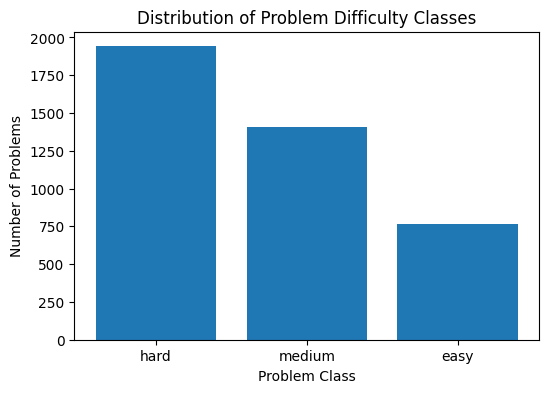

In [44]:
class_counts = data['problem_class'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Problem Class")
plt.ylabel("Number of Problems")
plt.title("Distribution of Problem Difficulty Classes")
plt.show()


In [45]:
data['problem_score'].describe()

,problem_score
count,4112.000000
mean,5.114689
std,2.177770
min,1.100000
25%,3.300000
50%,5.200000
75%,6.900000
max,9.700000


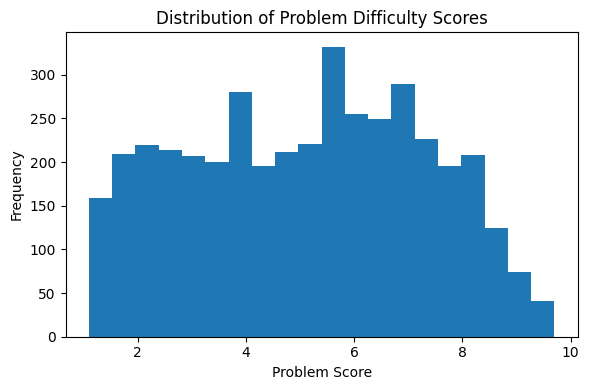

In [46]:
plt.figure(figsize=(6, 4))
plt.hist(data['problem_score'], bins=20)
plt.xlabel("Problem Score")
plt.ylabel("Frequency")
plt.title("Distribution of Problem Difficulty Scores")
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

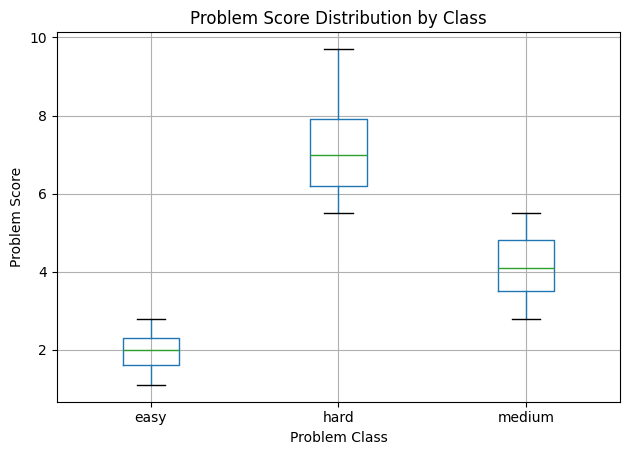

In [47]:
plt.figure(figsize=(6, 4))
data.boxplot(column='problem_score', by='problem_class')
plt.xlabel("Problem Class")
plt.ylabel("Problem Score")
plt.title("Problem Score Distribution by Class")
plt.suptitle("")
plt.tight_layout()
plt.show()


Feature Engineering

In [48]:
data['full_text'] = (
    data['title'] + " " +
    data['description'] + " " +
    data['input_description'] + " " +
    data['output_description']
)

In [49]:
data = data.drop(columns=['title','description','input_description','output_description'], axis=1)

In [50]:
data

,problem_class,problem_score,full_text
0,hard,9.7,Uuu Unununium (Uuu) was the name of the chemic...
1,hard,9.7,House Building A number of eccentrics from cen...
2,hard,9.6,Mario or Luigi Mario and Luigi are playing a g...
3,hard,9.6,The Wire Ghost Žofka is bending a copper wire....
4,hard,9.6,Barking Up The Wrong Tree Your dog Spot is let...
...,...,...,...
4107,easy,1.1,Tölvunarfræðingar telja Computer scientists co...
4108,easy,1.1,Velkomin! Welcome to Forritunarkeppni Framhald...
4109,easy,1.1,Til hamingju There is no input in this proble...
4110,easy,1.1,Hipp Hipp There is no input in this problem. ...


In [51]:
keywords = [
    'graph', 'tree', 'dp', 'modulo'
]

def extract_features(row):
    raw_txt = row['full_text']

    features = {}
    features['text_len'] = len(raw_txt)
    features['math_density'] = raw_txt.count('$') + raw_txt.count('\\') + raw_txt.count('{')

    for kw in keywords:
        features[f'has_{kw}'] = 1 if kw in raw_txt else 0

    return pd.Series(features)

heuristic_data = data.apply(extract_features, axis=1)
print("Heuristic features extracted:")
display(heuristic_data.head())

Heuristic features extracted:


,text_len,math_density,has_graph,has_tree,has_dp,has_modulo
0,1672,24,1,0,0,0
1,1422,37,0,0,0,0
2,1334,37,0,0,0,0
3,1390,27,0,0,0,0
4,2261,26,0,1,0,0


Vector embedding creation

In [52]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(data['full_text'])

Concatenating the data

In [53]:
X_heuristic = heuristic_data.values
X_final = hstack([X_tfidf, X_heuristic])

Encoding the target column for classification

In [54]:
le = LabelEncoder()
y_class = le.fit_transform(data['problem_class'])
print("Class Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
y_score = data['problem_score'].values

Class Mapping: {'easy': np.int64(0), 'hard': np.int64(1), 'medium': np.int64(2)}


Train-test splitting

In [55]:
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X_final, y_class, y_score, test_size=0.2, random_state=42
)

print("Data Split Successfully!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Data Split Successfully!
Training samples: 3289
Testing samples: 823


Classification model training

In [62]:
clf_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

print("Training Classification Model...")
clf_model.fit(X_train, y_class_train)
y_class_pred = clf_model.predict(X_test)

print("\n--- Classification Results ---")
print(classification_report(y_class_test, y_class_pred, target_names=le.classes_))
print(f"Accuracy: {accuracy_score(y_class_test, y_class_pred):.2f}")

Training Classification Model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:58:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Classification Results ---
              precision    recall  f1-score   support

        easy       0.57      0.35      0.43       136
        hard       0.62      0.76      0.68       425
      medium       0.40      0.34      0.37       262

    accuracy                           0.56       823
   macro avg       0.53      0.48      0.49       823
weighted avg       0.54      0.56      0.54       823

Accuracy: 0.56


Regression Model Training

In [57]:
reg_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
print("Training Regression Model...")
reg_model.fit(X_train, y_score_train)

y_score_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_score_test, y_score_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_score_pred))

print("\n--- Regression Results ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Training Regression Model...

--- Regression Results ---
Mean Absolute Error (MAE): 1.65
Root Mean Squared Error (RMSE): 2.01


Creating pkl files for use in web interface

In [58]:
joblib.dump(clf_model, 'difficulty_classifier.pkl')
joblib.dump(reg_model, 'score_regressor.pkl')

joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Saved 4 files: classifier, regressor, vectorizer, and label_encoder.")

Saved 4 files: classifier, regressor, vectorizer, and label_encoder.
